In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from astropy.stats import sigma_clip
from scipy.signal import medfilt
import pymc3 as pm
import exoplanet as xo
import everest
import logging
logging.root.level = 40

rotators = np.array(np.loadtxt('papersample.txt', skiprows=1, delimiter=',', usecols=[-2]), dtype=int)

In [47]:
import celerite2.theano
from celerite2.theano import terms as theano_terms

def acf_period(x, y, sigma=5, flatten=True, savgol_window=3001):
    mask = ~sigma_clip(y, sigma=5).mask
    x, y = x[mask], y[mask]
    
    if flatten:
        y = y - savgol_filter(y, savgol_window, 1)
    
    res = xo.autocorr_estimator(x, y, smooth=10)['autocorr']
    lag, acf = res
    
    res = find_peaks(acf, prominence=0.01)
    peaks = lag[res[0]]
    heights = acf[res[0]]
    prom = res[1]['prominences']
    
    if len(peaks) == 0:
        return -1, x, y
    elif len(peaks) == 1:
        return peaks[0], x, y

    candidate_period = peaks[0]
    if prom[1] > prom[0]:
        candidate_period = peaks[1]

    p = np.array([])
    for i in range(1, 10):
        window_center = i * candidate_period
        window = (window_center - 0.2 * candidate_period, 
                  window_center + 0.2 * candidate_period)
    
        in_window = (window[0] < peaks) & (peaks < window[1])
        if sum(in_window) == 0:
            break
        elif sum(in_window) == 1:
            p = np.append(p, peaks[in_window][0])
        elif sum(in_window) == 2:
            p = np.append(p, peaks[in_window][1])
        elif sum(in_window) > 2:
            p = np.append(p, peaks[int(np.mean(np.arange(0, len(peaks))[in_window]))])
    
    if len(p) <= 1:
        return -1, x, y
    else:
        return np.mean(np.diff(p)), x, y

def gp_period(x, y, sigma=5, flatten=True, savgol_window=3001, mcmc=False):
    
    period_guess, x, y = acf_period(x, y, sigma=sigma, 
                                    flatten=flatten, 
                                    savgol_window=savgol_window)
    
    print("initial guess froma ACF: ", period_guess)
    
    yerr = np.std(y - medfilt(y, kernel_size=11))
        
    with pm.Model() as model:
    
            mean = pm.Normal("mean", mu=np.mean(y), sd=np.std(y))
            yerr = pm.Normal("yerr", mu=yerr, sd=5.0)
            
            logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5)
            period = pm.Normal("period", mu=period_guess, sd=10)
            logQ0 = pm.Uniform("logQ0", lower=-10, upper=10)
            logdQ = pm.Normal("logdQ", mu=2.0, sd=5.0)
            mix = pm.Uniform("mix", lower=0.0, upper=1.0)
    
            logS0 = pm.Normal("logS0", mu=np.log(np.var(y)), sd=5)
            logw = pm.Uniform("logw", lower=-20, upper=0)
            
            kernel = theano_terms.SHOTerm(
                S0 = pm.math.exp(logS0),
                w0 = pm.math.exp(logw),
                Q = 1 / pm.math.sqrt(2)
            )  
            kernel += theano_terms.RotationTerm(
                sigma = pm.math.exp(logamp),
                period = period,
                Q0 = pm.math.exp(logQ0),
                dQ = pm.math.exp(logdQ),
                f = mix
            )
            
            gp = celerite2.theano.GaussianProcess(kernel, mean=0.0)
            gp.compute(x, diag = yerr ** 2, quiet=True)
            gp.marginal("gp", observed = y)

            if mcmc:
                trace = pm.sample(
                    tune=1000,
                    draws=1000,
                    target_accept=0.9,
                    cores=2,
                    chains=2
                )
                return trace
            
            else:
                mapsoln = pm.find_MAP()
                print("maximum likelihood period estimate: ", mapsoln['period'])
                return mapsoln

In [48]:
i = np.random.randint(len(rotators))
lc = everest.Everest(rotators[i])
y = lc.fcor
x = lc.time
mask = sigma_clip(y, sigma=3, masked=True).mask
x, y = np.array(x[~mask], dtype='float64'), np.array(y[~mask], dtype='float64')

INFO  [everest.user.DownloadFile()]: Downloading the file...
INFO  [everest.user.load_fits()]: Loading FITS file for 211921966.
WARNING [astropy._showwarning()]: Input data contains invalid values (NaNs or infs), which were automatically clipped.


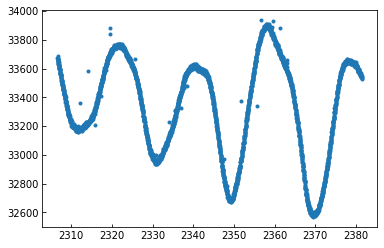

In [49]:
plt.plot(x, y, '.')

In [50]:
logger = logging.getLogger()
logger.disabled = True
mapsoln = gp_period(x, y)

initial guess froma ACF:  18.87886776925734



maximum likelihood period estimate:  19.55517263026929


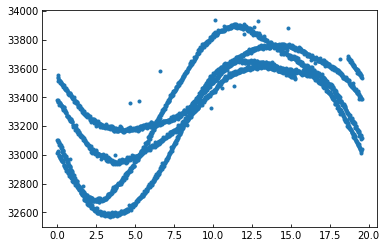

In [52]:
plt.plot(x % mapsoln['period'], y, '.')